In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
from scipy import constants


import torch
import torch.nn as nn
from torch.nn import ReLU
import torch.utils.data as td
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

In [23]:
# trainning and validation data
all_data=pd.read_csv('all.csv',index_col=False,header=None)
shuffled_data=all_data.sample(frac = 1)
# feature=pd.read_csv('features.csv',index_col=False,header=None)
# target=pd.read_csv('target.csv',index_col=False,header=None)
feature=shuffled_data.iloc[:, 0:784]
target=shuffled_data.iloc[:, 784]

In [28]:
### Reading values only for trainning data
feature_in=feature.values
target_in=target.values

# converting to tensor train data
feature_tensor=torch.Tensor(feature_in)[0:2000]
target_tensor=torch.Tensor(target_in)[0:2000]

# converting to tensor test data
feature_tensor_test=torch.Tensor(feature_in)[2000:3000]
target_tensor_test=torch.Tensor(target_in)[2000:3000]

In [34]:
train=[*zip(feature_tensor,target_tensor)]
train_loader= DataLoader(train,batch_size=10,shuffle=True)


for image,labels in train_loader:
        print('Initial Batch shape:',image.size())
        break
print('batch shape after flattening',image.view(10,-1).size())


test=[*zip(feature_tensor_test,target_tensor_test)]
test_loader= DataLoader(test,batch_size=10,shuffle=True)

Initial Batch shape: torch.Size([10, 784])
batch shape after flattening torch.Size([10, 784])


In [87]:
class MLP(nn.Module):
        def __init__(self,input_size=784,output_size=10,layers=[64,32]):
                super().__init__()
                self.x1=nn.Linear(input_size,layers[0])
                self.x2=nn.Linear(layers[0],layers[1])
                self.x3=nn.Linear(layers[1],output_size)

        def forward(self,X):
                X=F.relu(self.x1(X))
                X=F.relu(self.x2(X))
                X= self.x3(X)
                return F.log_softmax(X,dim=1)

model=MLP()
print(model)

MLP(
  (x1): Linear(in_features=784, out_features=64, bias=True)
  (x2): Linear(in_features=64, out_features=32, bias=True)
  (x3): Linear(in_features=32, out_features=10, bias=True)
)


In [88]:
criterion=nn.CrossEntropyLoss()
learning_rate=0.0001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
epochs =20
train_loss=[]
test_losses=[]
train_correct=[]
test_correct=[]
epoch_nums = []
for i in range(epochs):
        trn_corr=0
        tst_corr=0
        
        for b,(X_train,y_train) in enumerate(train_loader):
                b+=1
                
                y_pred=model(X_train)
                loss=criterion(y_pred,torch.flatten(y_train).type(torch.LongTensor))

                predicted=torch.max(y_pred.data,1)[1]
                batch_corr=(predicted==torch.flatten(y_train).type(torch.LongTensor)).sum()
                
                trn_corr+=batch_corr

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
               
                if b%200 == 0:
                        epoch_nums.append(i)
                        train_loss.append(loss)  
                        train_correct.append(trn_corr)
                        print(f'epoch:{i:2} batch: {b:4} Train loss: {loss} Train accuracy: {(trn_corr/2000)*100} ')
                        print(batch_corr)
                
                


with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
                y_val=model(X_test)

                predicted_test=torch.max(y_val.data,1)[1]
                tst_corr+=(predicted_test==torch.flatten(y_test).type(torch.LongTensor)).sum()
                
loss_test= criterion(y_val,torch.flatten(y_test).type(torch.LongTensor))
test_losses.append(loss)
test_correct.append(tst_corr)

print(f'Test loss: {loss_test} Test accuracy: {(tst_corr/1000)*100}')

epoch: 0 batch:  200 Train loss: 1.356368899345398 Train accuracy: 38.10000228881836 
tensor(5)
epoch: 1 batch:  200 Train loss: 1.0321180820465088 Train accuracy: 67.79999542236328 
tensor(6)
epoch: 2 batch:  200 Train loss: 0.24031174182891846 Train accuracy: 80.8499984741211 
tensor(9)
epoch: 3 batch:  200 Train loss: 0.3276529014110565 Train accuracy: 86.5999984741211 
tensor(8)
epoch: 4 batch:  200 Train loss: 0.39760512113571167 Train accuracy: 90.5999984741211 
tensor(9)
epoch: 5 batch:  200 Train loss: 0.09425204992294312 Train accuracy: 93.69999694824219 
tensor(10)
epoch: 6 batch:  200 Train loss: 0.17673835158348083 Train accuracy: 95.3499984741211 
tensor(10)
epoch: 7 batch:  200 Train loss: 0.030949652194976807 Train accuracy: 97.19999694824219 
tensor(10)
epoch: 8 batch:  200 Train loss: 0.023634450510144234 Train accuracy: 98.0 
tensor(10)
epoch: 9 batch:  200 Train loss: 0.06188122555613518 Train accuracy: 98.94999694824219 
tensor(10)
epoch:10 batch:  200 Train loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

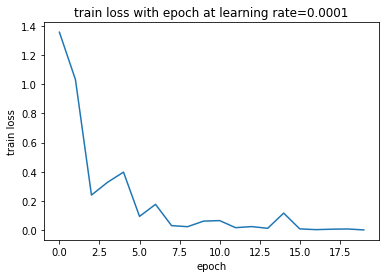

In [89]:
tensor_trainning_loss = torch.tensor(train_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title(f'train loss with epoch at learning rate={learning_rate}')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error